In [2]:
import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)

In [3]:
from pathlib import Path
import pandas as pd
from bitis.texture.properties import (
    PatternPropertiesBuilder,
)


def calc_props(image, area_min=10, area_quantile=0.95):
    pattern_builder = PatternPropertiesBuilder(area_quantile=area_quantile,
                                               area_min=area_min)
    pattern_props = pattern_builder.build(image == 2)
    return pattern_props, pattern_builder.object_props


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


def make_pattern_stats(path, pattern_ids, n_samples=100):
    
    all_pattern_props = []
    all_object_props = []
    for pattern_id in pattern_ids:
        for i in range(n_samples):
            image = read_image(path.joinpath(f'simulated_{pattern_id}',
                                             f'gen_tex_{pattern_id}_{i}.png'))
            
            pattern_props, object_props = calc_props(image)
            pattern_props['pattern_id'] = pattern_id

            object_props['pattern_id'] = pattern_id
            object_props['sample_id'] = i

            all_pattern_props.append(pattern_props)
            all_object_props.append(object_props)
    
    all_pattern_props = pd.concat(all_pattern_props).reset_index(drop=True)
    all_object_props = pd.concat(all_object_props).reset_index(drop=True)
    return all_pattern_props, all_object_props


# path = Path('/Users/arstanbek/Projects/BiTis/data')
path = Path('/home/arstan/Projects/Fibrosis/BiTis/data')
pattern_ids = [25, 2, 34, 5]
data, _ = make_pattern_stats(path, pattern_ids, n_samples=100)
data['orientation'] = np.degrees(data['orientation'])
data['orientation'] = (data['orientation'] + 90) % 180 - 90

In [27]:
data.head()

,density,elongation,orientation,compactness,structural_anisotropy,solidity,pattern_id,source
0,0.1927,4.364964,-26.635084,0.0910,7.362689,0.715216,25,ds
1,0.2366,3.848897,-27.904303,0.1203,6.578262,0.717943,25,ds
2,0.2370,3.525871,-25.861050,0.1143,8.706258,0.739821,25,ds
3,0.2038,4.028403,-27.110351,0.0950,7.244251,0.674909,25,ds
4,0.1972,3.973672,-24.640268,0.0839,9.651822,0.748067,25,ds


In [44]:
uni_data = []
tr_data = []

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training',
                                        f'or_tex_{pattern_id}.png'))
    oprops, _ = calc_props(tr_image)
    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0
    tr_data.append(oprops)

    # Generate uniform image
    dens = np.mean(tr_image == 2)
    uni_image = 1 + (np.random.random(tr_image.shape) <= dens).astype(int)
    oprops, _ = calc_props(uni_image)

    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0

    uni_data.append(oprops)


tr_data = pd.concat(tr_data).reset_index(drop=True)
tr_data['orientation'] = np.degrees(tr_data['orientation'])
tr_data['orientation'] = (tr_data['orientation'] + 90) % 180 - 90

uni_data = pd.concat(uni_data).reset_index(drop=True)
uni_data['orientation'] = np.degrees(uni_data['orientation'])
uni_data['orientation'] = 0

/home/arstan/Projects/Fibrosis/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')


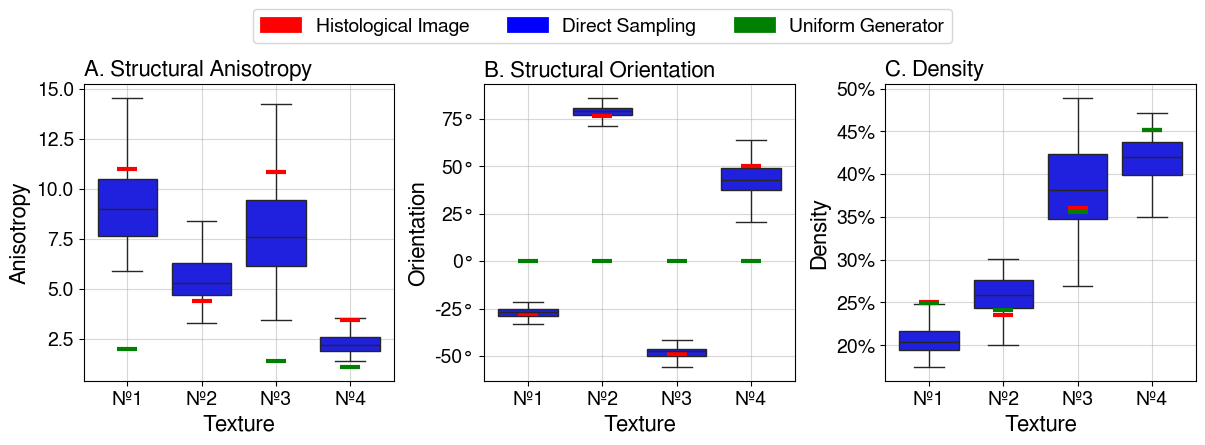

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib as mpl

plt.rc('font', family='FreeSans')


fig, axs = plt.subplots(ncols=3, figsize=(12, 4.5))
for i, prop_name in enumerate(['structural_anisotropy', 'orientation',
                               'density']):
    ax = axs[i]
    sns.boxplot(x='pattern_id', y=prop_name, data=data,
                order=pattern_ids, ax=ax, linewidth=1, hue='source',
                hue_order=['tr', 'ds', 'uni'],
                palette=['red', 'blue', 'green'], legend=False,
                showfliers=False)
    ax.plot(tr_data[prop_name], marker='_', markersize=15, markeredgewidth=3,
            ls='', color='r', label='Training Image')
    ax.plot(uni_data[prop_name], marker='_', markersize=15, markeredgewidth=3,
            ls='', color='g', label='Uniform Generator')
    
titles = ['A. Structural Anisotropy', 'B. Structural Orientation',
          'C. Density']
for ax, title in zip(axs, titles):
    ax.set_title(title, fontsize=16, loc='left')
    ax.set_ylabel(title.split()[-1], fontsize=16)
    ax.set_xticks(np.arange(len(pattern_ids)),
                  [f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                  fontsize=16)
    ax.set_xlabel('Texture', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, which='both', alpha=0.5)

axs[1].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}°'))

axs[2].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{100 * x:.0f}%'))

legend_patches = [mpatches.Patch(facecolor='red', edgecolor='red',
                                 linewidth=2, label='Histological Image'),
                  mpatches.Patch(facecolor='blue', edgecolor='blue',
                                 linewidth=2, label='Direct Sampling'),
                  mpatches.Patch(facecolor='green', edgecolor='green',
                                 linewidth=2, label='Uniform Generator')]
fig.legend(handles=legend_patches, loc='upper center',
           ncol=3, prop={'size': 14})
plt.tight_layout(rect=[0, 0, 1, 0.9], h_pad=1, w_pad=1)
plt.show()

In [59]:
path_save = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('generation_quality_images.png'),
            dpi=300, bbox_inches='tight')